<a href="https://colab.research.google.com/github/JaymeNeto/cluster-de-alugueis/blob/master/analise_e_clusterizacao_de_alugueis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nesse Notebook eu faço uma exploração dos dados de um dataset de valores de aluguel de imoveis.

Fazendo uma analise vou tentar devendar:

* Quais parametros mais influenciam no preço do aluguel.

* Fazer uma analise de clusterização do conjunto geral X cada clusterização por cidade


In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
rent = pd.read_csv('houses_to_rent_v2.csv')
rent['furniture'] = pd.get_dummies(rent.furniture)['furnished']
rent['animal'] = pd.get_dummies(rent.animal)['acept']

rent.columns = ['Cidade','Area', 'Quartos', 'Banheiros', 'Vagas', 'Andar', 'Permite Animal', 'Mobiliado', 'Condominio', 'Aluguel', 'IPTU', 'Seguro', 'Total']
rent['Tx. IPTU'] = 100*rent['IPTU']/rent['Aluguel']
rent['Tx. Seguro'] = 100*rent['Seguro']/rent['Aluguel']
dados_bina = ['Permite Animal', 'Mobiliado']
dados_cont = ['Area', 'IPTU', 'Seguro', 'Total', 'Tx. IPTU', 'Tx. Seguro']
dados_disc = ['Quartos', 'Banheiros', 'Andar']
rent

Cidade  Area  Quartos  ...  Total   Tx. IPTU Tx. Seguro
0           São Paulo    70        2  ...   5618   6.393939   1.272727
1           São Paulo   320        4  ...   7973  35.282258   1.270161
2        Porto Alegre    80        1  ...   3841   0.000000   1.464286
3        Porto Alegre    51        2  ...   1421   1.978417   1.528777
4           São Paulo    25        1  ...    836   3.125000   1.375000
...               ...   ...      ...  ...    ...        ...        ...
10687    Porto Alegre    63        2  ...   1926   1.623816   1.488498
10688       São Paulo   285        4  ...  19260   6.486667   1.273333
10689  Rio de Janeiro    70        3  ...   7390   5.533333   1.300000
10690  Rio de Janeiro   120        2  ...  14020   2.325000   1.291667
10691       São Paulo    80        2  ...   1587  11.785714   1.571429

[10692 rows x 15 columns]

Tipo dos dados:

In [3]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cidade          10692 non-null  object 
 1   Area            10692 non-null  int64  
 2   Quartos         10692 non-null  int64  
 3   Banheiros       10692 non-null  int64  
 4   Vagas           10692 non-null  int64  
 5   Andar           10692 non-null  object 
 6   Permite Animal  10692 non-null  uint8  
 7   Mobiliado       10692 non-null  uint8  
 8   Condominio      10692 non-null  int64  
 9   Aluguel         10692 non-null  int64  
 10  IPTU            10692 non-null  int64  
 11  Seguro          10692 non-null  int64  
 12  Total           10692 non-null  int64  
 13  Tx. IPTU        10692 non-null  float64
 14  Tx. Seguro      10692 non-null  float64
dtypes: float64(2), int64(9), object(2), uint8(2)
memory usage: 1.1+ MB


Como andar é um object criei uma função para torna-lo um int. O caracter '-' representa as casa e vou passar a representa-lo como valor 0.

In [4]:
def muda_tipo(s):
    try:
        return int(s)
    except:
        return 0
rent.Andar = rent.Andar.map(muda_tipo)

Analisando as estatisticas do dataframe.

In [5]:
rent.describe()

Area       Quartos  ...      Tx. IPTU    Tx. Seguro
count  10692.000000  10692.000000  ...  10692.000000  10692.000000
mean     149.217920      2.506079  ...      8.648820      1.366721
std      537.016942      1.171266  ...    122.152895      0.151004
min       11.000000      1.000000  ...      0.000000      0.269703
25%       56.000000      2.000000  ...      2.142857      1.282889
50%       90.000000      2.000000  ...      5.212500      1.313131
75%      182.000000      3.000000  ...      9.175986      1.500000
max    46335.000000     13.000000  ...  12548.000000      1.875000

[8 rows x 14 columns]

Em varias colunas percebo que o valor maximo está muito distante do terceiro quartil então farei uma limpeza dos outliers.

# Tratando Outliers.

## Area

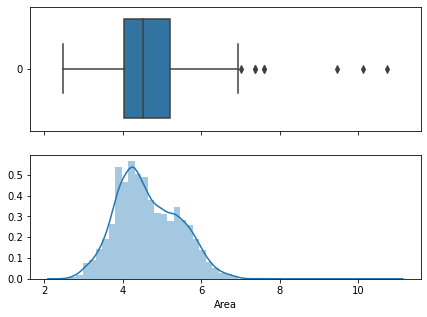

In [48]:


def outliers_analise(dados):
  f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
  sns.boxplot(data=dados, ax=ax1, orient='h')
  sns.distplot(dados, ax=ax2)

outliers_analise(rent.Area)

In [29]:
quartil = np.quantile(rent.Area, 0.999, axis=0)

rent[rent.Area >= quartil]

Cidade   Area  Quartos  ...  Total   Tx. IPTU  Tx. Seguro
640    Belo Horizonte   1000        5  ...  17130  12.710280    1.642190
654         São Paulo   1600        6  ...   9549  24.131579    1.513158
1250        São Paulo   1000        4  ...  26090  32.666667    1.273333
2397   Belo Horizonte  46335        4  ...  10220   7.600000    1.341176
2423   Belo Horizonte   1020        5  ...   7281  10.030675    1.641104
3052   Belo Horizonte   1000        3  ...   5447   7.300000    1.640000
3559        São Paulo   1100        4  ...  19210  14.285714    1.507143
4813        São Paulo   1600        4  ...  12010  72.463768    1.507246
5129   Belo Horizonte   2000        4  ...   5238   4.035513    1.654560
5915        São Paulo  24606        5  ...  18320  97.024691    1.271605
6615   Belo Horizonte   1000        5  ...   8983   9.057143    1.342857
8790   Belo Horizonte   2000        3  ...   8267   4.000000    1.340000
9241         Campinas  12732        3  ...   2417   6.000000    1.312500
9857        São Paulo   1000        4  ...  17560  15.560000    1.506667
10184       São Paulo   1000        4  ...  19420  61.323529    1.279412

[15 rows x 15 columns]

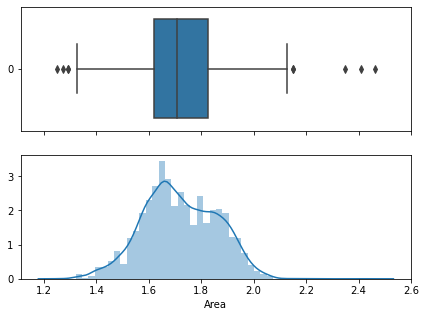

In [49]:
outliers_analise(np.log1p(rent["Area"]))

In [45]:
rent.Area = rent.Area.map(np.log1p)

## Aluguel

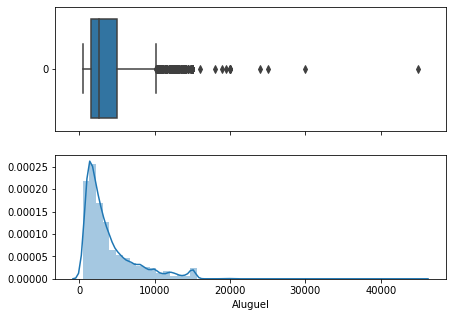

In [50]:
outliers_analise(rent.Aluguel)

In [54]:
#quartil = np.quantile(rent.Aluguel, 0.999, axis=0)

#rent[rent.Aluguel >= quartil]

rent.sort_values(by=['Aluguel']).tail(15)

Cidade      Area  Quartos  ...   Total   Tx. IPTU  Tx. Seguro
5251  Rio de Janeiro  6.008813        3  ...   19560   7.780000    1.293333
9663  Belo Horizonte  5.484797        4  ...   17990   7.233333    1.333333
6118       São Paulo  5.484797        4  ...   20570  10.418750    1.268750
5741       São Paulo  5.717028        3  ...   22770   0.000000    1.272222
2521    Porto Alegre  5.765191        4  ...   19720   2.021053    1.778947
6185       São Paulo  6.122493        4  ...   31580  17.097436    1.271795
2859       São Paulo  5.655992        4  ...  222100   9.170000    1.270000
1743       São Paulo  6.018593        4  ...   20250   0.000000    1.270000
1253       São Paulo  5.755742        3  ...   25510   4.795000    1.270000
157        São Paulo  6.493754        4  ...   26800   8.750000    1.270000
5525       São Paulo  6.803505        3  ...   24110  19.065000    1.505000
2619       São Paulo  4.394449        2  ...   25180   0.000000    1.270833
6947       São Paulo  6.188264        8  ...   27580   8.800000    1.504000
7748       São Paulo  5.860786        3  ...   31010   1.866667    1.503333
2182       São Paulo  6.552508        4  ...   54430  19.444444    1.504444

[15 rows x 15 columns]

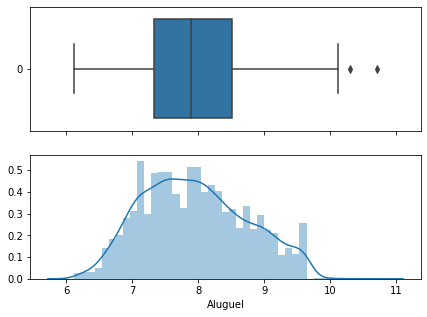

In [55]:
outliers_analise(np.log1p(rent.Aluguel))

In [56]:
rent.Aluguel = rent.Aluguel.map(np.log1p)

In [57]:
rent

Cidade      Area  Quartos  ...  Total   Tx. IPTU  Tx. Seguro
0           São Paulo  4.262680        2  ...   5618   6.393939    1.272727
1           São Paulo  5.771441        4  ...   7973  35.282258    1.270161
2        Porto Alegre  4.394449        1  ...   3841   0.000000    1.464286
3        Porto Alegre  3.951244        2  ...   1421   1.978417    1.528777
4           São Paulo  3.258097        1  ...    836   3.125000    1.375000
...               ...       ...      ...  ...    ...        ...         ...
10687    Porto Alegre  4.158883        2  ...   1926   1.623816    1.488498
10688       São Paulo  5.655992        4  ...  19260   6.486667    1.273333
10689  Rio de Janeiro  4.262680        3  ...   7390   5.533333    1.300000
10690  Rio de Janeiro  4.795791        2  ...  14020   2.325000    1.291667
10691       São Paulo  4.394449        2  ...   1587  11.785714    1.571429

[10692 rows x 15 columns]

In [58]:
rent.describe()

Area       Quartos  ...      Tx. IPTU    Tx. Seguro
count  10692.000000  10692.000000  ...  10692.000000  10692.000000
mean       4.633334      2.506079  ...      8.648820      1.366721
std        0.794938      1.171266  ...    122.152895      0.151004
min        2.484907      1.000000  ...      0.000000      0.269703
25%        4.043051      2.000000  ...      2.142857      1.282889
50%        4.510860      2.000000  ...      5.212500      1.313131
75%        5.209486      3.000000  ...      9.175986      1.500000
max       10.743674     13.000000  ...  12548.000000      1.875000

[8 rows x 14 columns]

In [60]:
rent.sort_values(by=['Andar']).tail(25)

Cidade      Area  Quartos  ...  Total   Tx. IPTU  Tx. Seguro
323         São Paulo  3.761200        1  ...   6028   1.886792    1.283019
10457       São Paulo  4.615121        2  ...   7318   5.856005    1.277372
2106        São Paulo  4.595120        1  ...  18500   0.866667    1.273333
5508        São Paulo  4.110874        2  ...   4092   2.909091    1.272727
7714        São Paulo  4.584967        2  ...  11430   0.000000    1.274510
2707        São Paulo  5.198497        3  ...   9242  13.215385    1.276923
6046        São Paulo  3.761200        1  ...   5977   1.904762    1.276190
9848        São Paulo  5.707110        4  ...  14000   8.715139    1.274900
7062        São Paulo  5.860786        3  ...  15670  11.808333    1.275000
8143        São Paulo  3.713572        1  ...   6507   7.571429    1.285714
3416        São Paulo  6.049733        4  ...  22610  18.907143    1.271429
2402        São Paulo  3.713572        1  ...   6507   7.571429    1.285714
8245        São Paulo  5.379897        4  ...   7589  13.140000    1.280000
10062       São Paulo  5.638355        4  ...  14860  12.321739    1.269565
5989        São Paulo  4.595120        2  ...  10510   5.294118    1.270588
4389        São Paulo  5.680173        4  ...   7450  13.720000    1.280000
2709        São Paulo  4.663439        1  ...  10530   4.793103    1.275862
5528   Belo Horizonte  5.723585        4  ...  21020  15.992857    1.335714
2522        São Paulo  4.356709        1  ...   8798   2.700258    1.279070
6096        São Paulo  4.442651        2  ...   9908   5.294118    1.270588
10179       São Paulo  3.951244        1  ...   3758   1.138462    1.292308
671         São Paulo  5.525453        3  ...  18780   7.226667    1.273333
1654        São Paulo  5.869297        4  ...  13130   0.000000    1.270000
5694         Campinas  4.174387        2  ...   2854   6.789474    1.315789
2562   Belo Horizonte  4.394449        3  ...   3549   6.307692    1.346154

[25 rows x 15 columns]

In [ ]:
def remove_outliers(data, label):
    #calculate the IQR
    IQR = data[label].quantile(0.75) - data[label].quantile(0.25)
    
    #calculate the boundries
    lower = data[label].quantile(0.25) - (IQR * 1.5)
    upper = data[label].quantile(0.75) + (IQR * 1.5)
    
    # find the outliers
    outliers = np.where(data[label] > upper, True, np.where(data[label] < lower, True, False))
    
    # remove outliers from data.
    return data.loc[~outliers] 

for label in ['Area', 'Aluguel', 'Quartos', 'Andar', 'IPTU','Condominio']:
    rent = remove_outliers(rent, label)

In [ ]:
rent.describe()

Area      Quartos  ...     Tx. IPTU   Tx. Seguro
count  7924.000000  7924.000000  ...  7924.000000  7924.000000
mean     92.129606     2.166078  ...     4.972967     1.369614
std      63.128317     0.965350  ...     4.750122     0.153305
min      11.000000     1.000000  ...     0.000000     0.311284
25%      50.000000     1.000000  ...     1.428571     1.289474
50%      72.000000     2.000000  ...     4.206258     1.327963
75%     112.000000     3.000000  ...     7.222222     1.489362
max     367.000000     6.000000  ...    62.500000     1.875000

[8 rows x 14 columns]

<Figure size 1152x864 with 0 Axes>

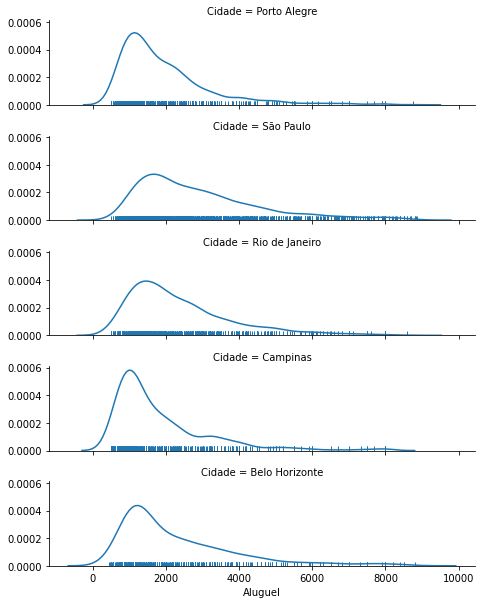

In [ ]:
plt.figure(figsize=(16, 12))
g = sns.FacetGrid(rent, row="Cidade", height=1.7, aspect=4,)
g.map(sns.distplot, "Aluguel", hist=False, rug=True)

<Figure size 1152x864 with 0 Axes>

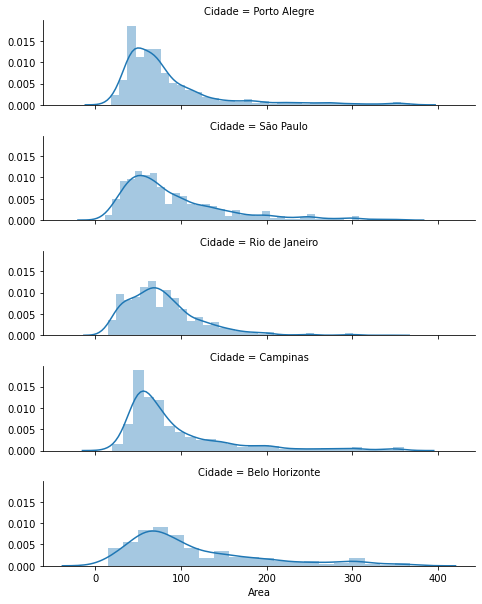

In [ ]:
plt.figure(figsize=(16, 12))
g = sns.FacetGrid(rent, row="Cidade", height=1.7, aspect=4,)
g.map(sns.distplot, "Area")

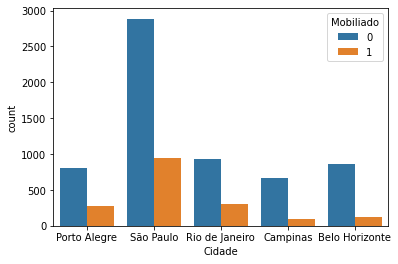

In [ ]:
ax = sns.countplot(x="Cidade", hue="Mobiliado", data=rent)

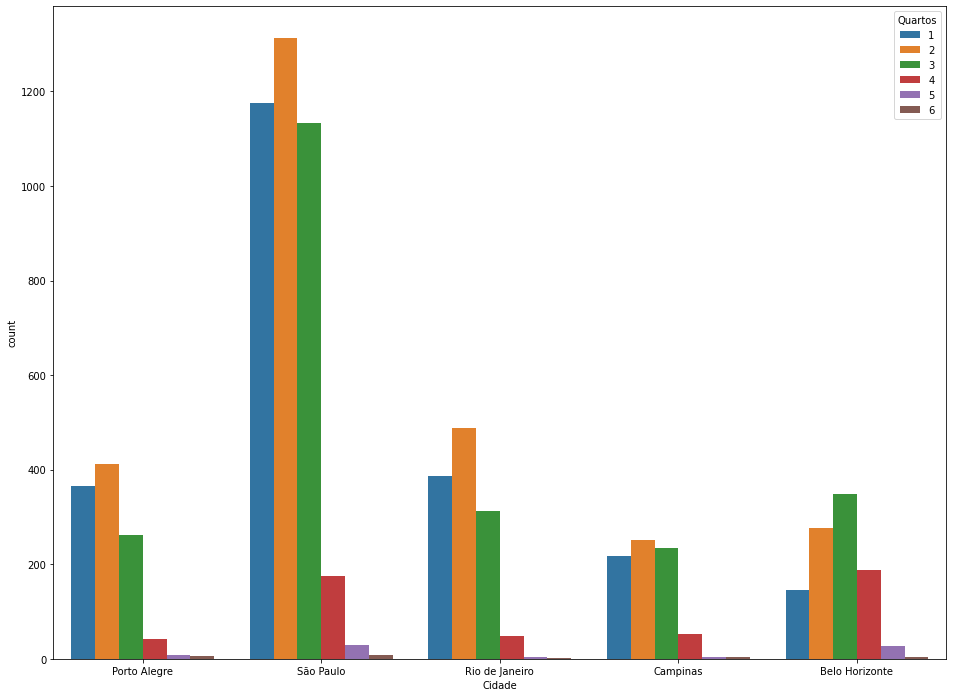

In [ ]:
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="Cidade", hue="Quartos", data=rent)

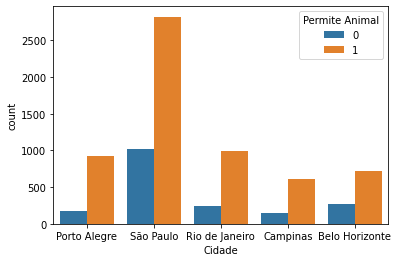

In [ ]:
ax = sns.countplot(x="Cidade", hue="Permite Animal", data=rent)

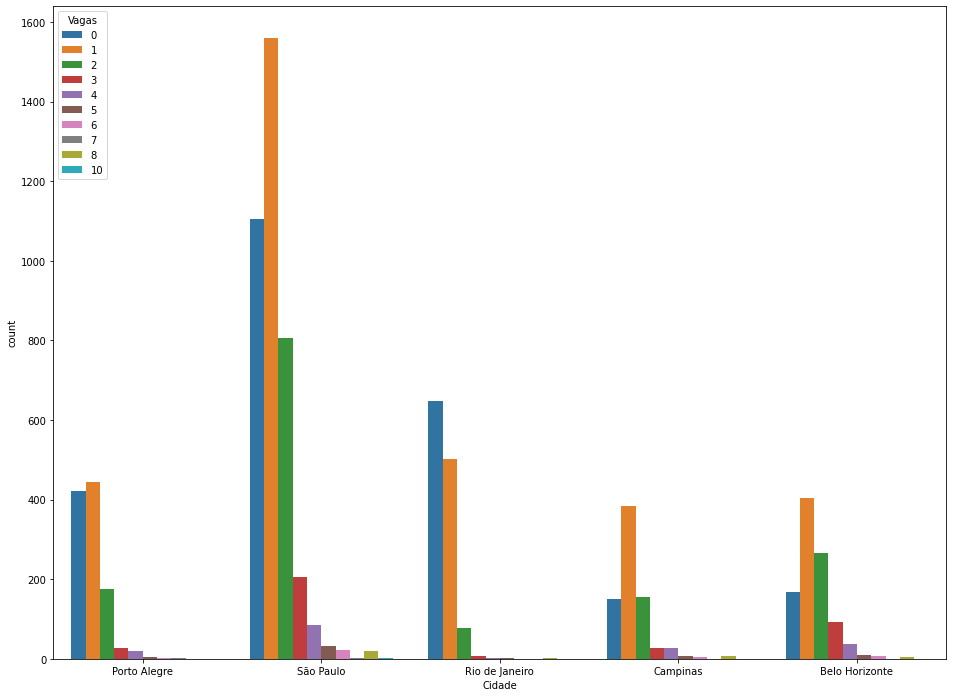

In [ ]:
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="Cidade", hue="Vagas", data=rent)

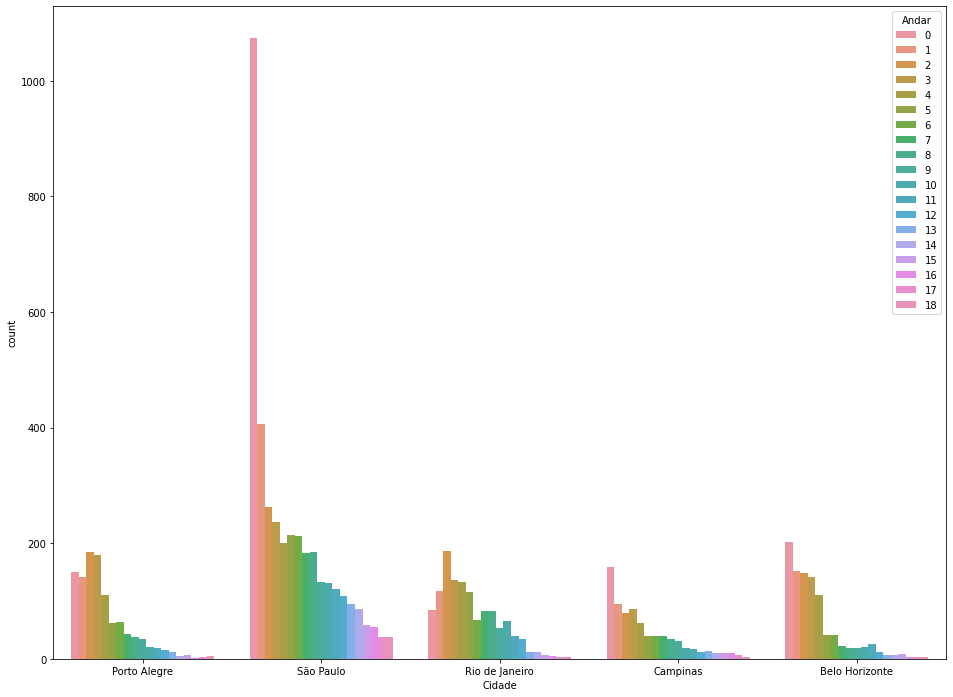

In [ ]:
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="Cidade", hue="Andar", data=rent)

# Analise de correlação

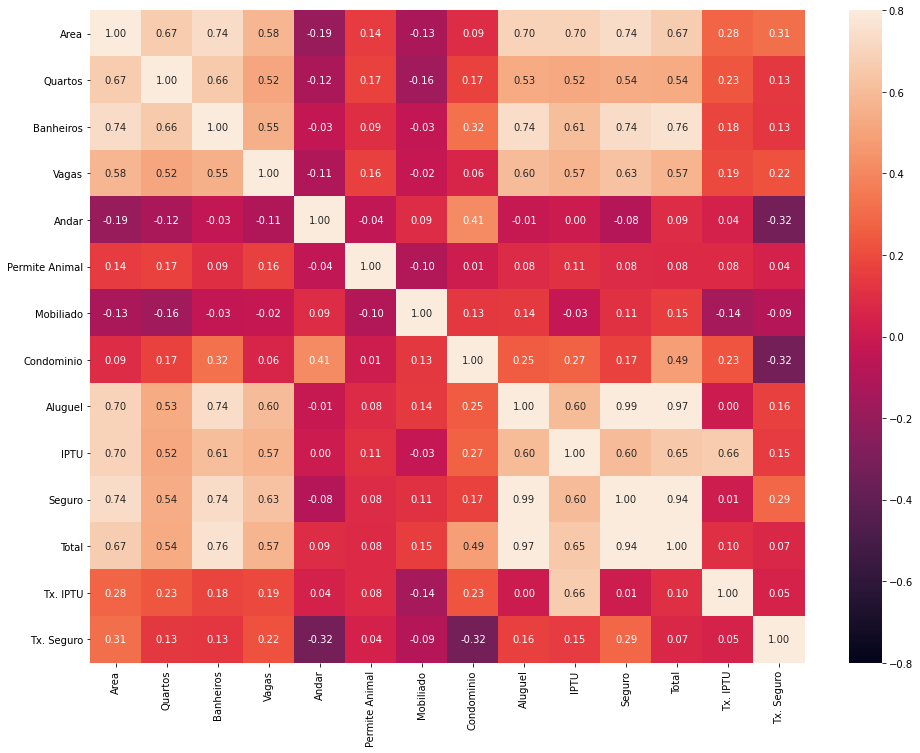

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16, 12))
sns.heatmap(campinas.corr(), annot=True, fmt='.2f', vmax=0.8, vmin=-0.8)
plt.show()

## Conclusão:

* O alugel tem uma relação media com Área (0.57), Quartos(0.42), banheiros(0.55) e  

# Aplicando redução de dimensionalidade.

In [ ]:
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)
kernel = KernelPCA(n_components=2)


imoveis_pca = pca.fit(rent[dados_cont]).transform(rent[dados_cont])
imoveis_svd = svd.fit(rent[dados_cont]).transform(rent[dados_cont])
imoveis_kernel = kernel.fit_transform(rent[dados_cont])

cidades = rent.Cidade.values.reshape((7924,1))

imoveis_pca = np.append(cidades, imoveis_pca, axis=1)
imoveis_pca = pd.DataFrame(data=imoveis_pca, columns=['Cidade', 'X', 'Y'])

imoveis_svd = np.append(cidades, imoveis_svd, axis=1)
imoveis_svd = pd.DataFrame(data=imoveis_svd, columns=['Cidade', 'X', 'Y'])

imoveis_kernel = np.append(cidades, imoveis_kernel, axis=1)
imoveis_kernel = pd.DataFrame(data=imoveis_kernel, columns=['Cidade', 'X', 'Y'])


cidades = np.unique(cidades.reshape((7924)))


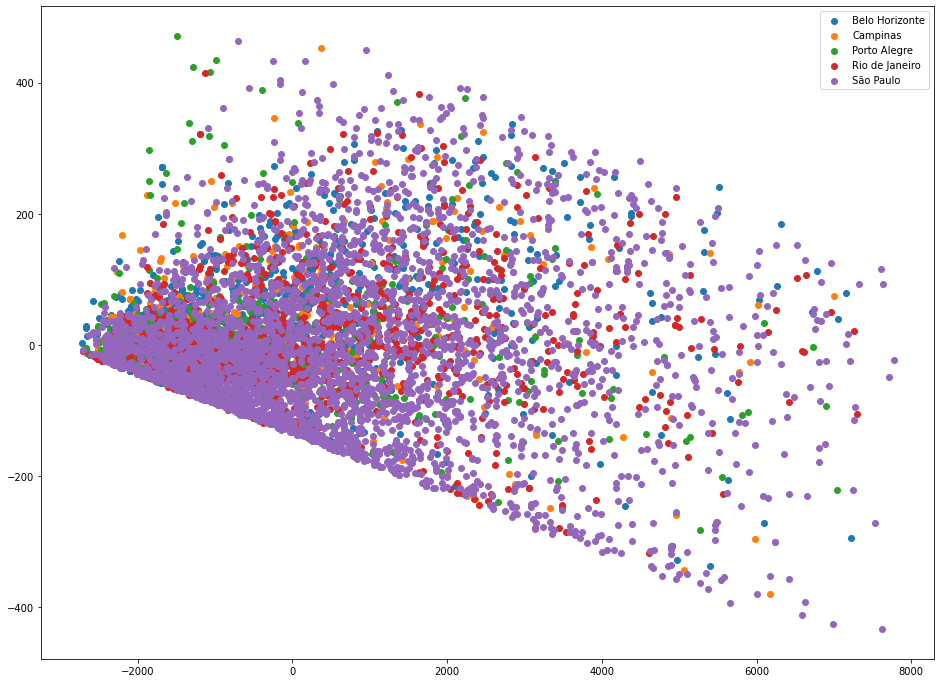

In [ ]:
plt.figure(figsize=(16, 12))
for cidade in cidades:
  plt.scatter(imoveis_kernel.query('Cidade == "%s"' % cidade)['X'], imoveis_kernel.query('Cidade == "%s"' % cidade)['Y'], label=cidade)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

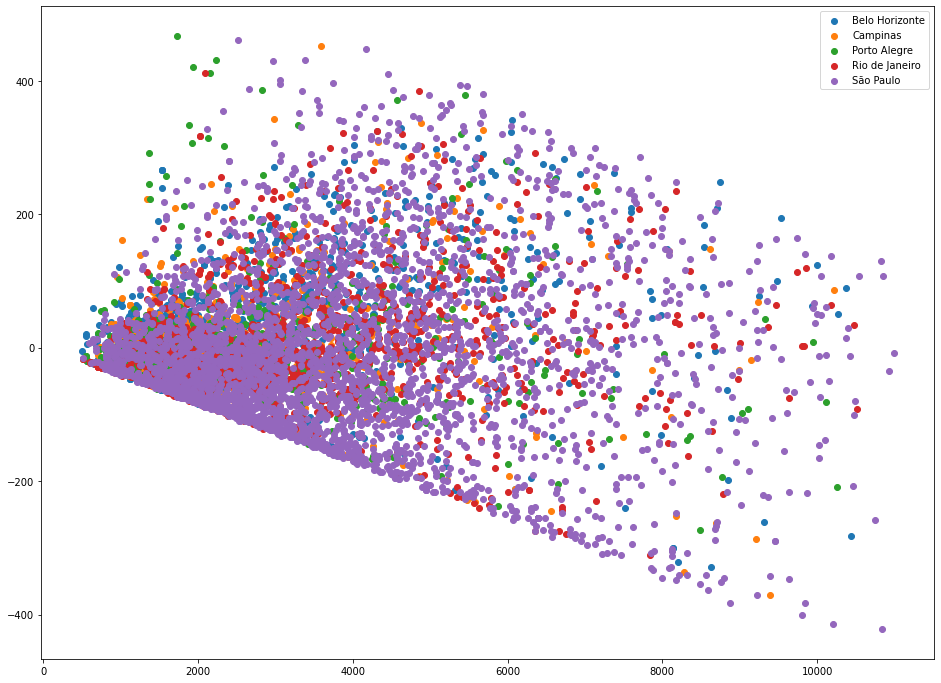

In [ ]:
plt.figure(figsize=(16, 12))
for cidade in cidades:
  plt.scatter(imoveis_svd.query('Cidade == "%s"' % cidade)['X'], imoveis_svd.query('Cidade == "%s"' % cidade)['Y'], label=cidade)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

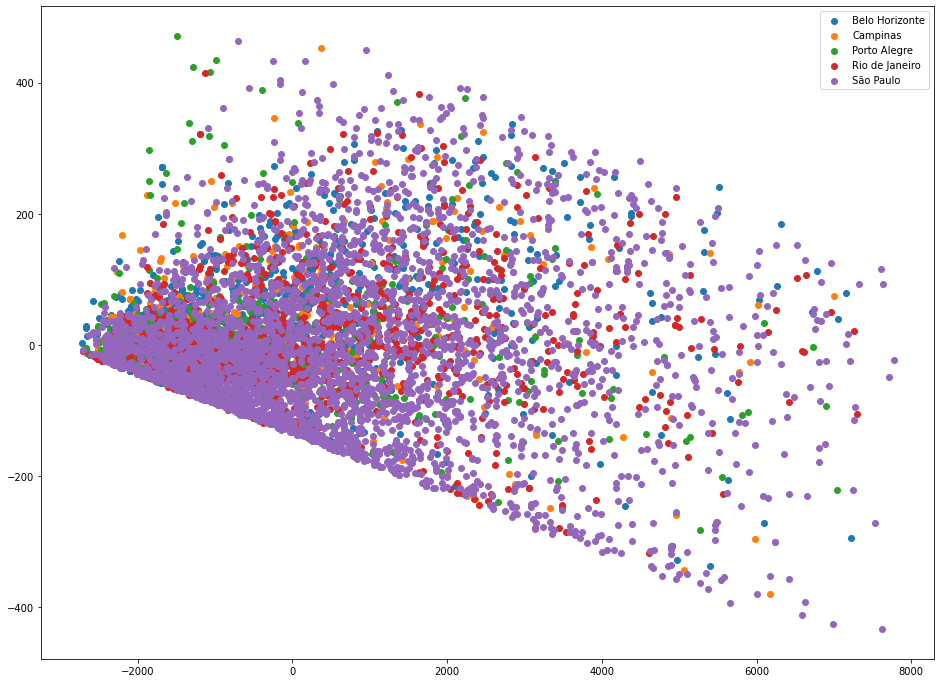

In [ ]:
plt.figure(figsize=(16, 12))
for cidade in cidades:
  plt.scatter(imoveis_pca.query('Cidade == "%s"' % cidade)['X'], imoveis_pca.query('Cidade == "%s"' % cidade)['Y'], label=cidade)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

In [ ]:
imoveis_pca.query("Cidade == Belo Horizonte")

SyntaxError: ignored

# Separando os dados por cidade.

In [ ]:
sao_paulo = rent.query('Cidade == "São Paulo"').drop(columns=['Cidade'])
rio_de_janeiro = rent.query('Cidade == "Rio de Janeiro"').drop(columns=['Cidade'])
belo_horizonte = rent.query('Cidade == "Belo Horizonte"').drop(columns=['Cidade'])
porto_alegre = rent.query('Cidade == "Porto Alegre"').drop(columns=['Cidade'])
campinas = rent.query('Cidade == "Campinas"').drop(columns=['Cidade'])

# Analise da relação do aluguel com outros valores pagos.

Quero analisar a relação do valor do aluguel com outros valores pagos, ou seja a taxa de consominio, o IPTU e o seguro contra incendio


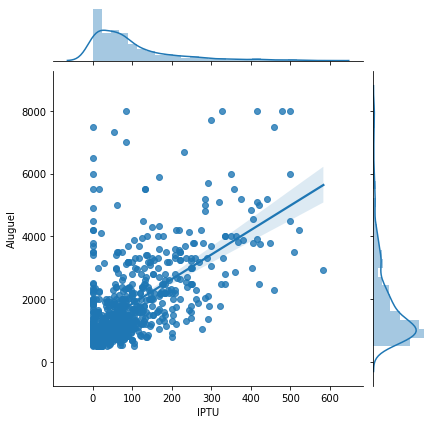

In [ ]:
sns.jointplot(y= campinas['Aluguel'],x = campinas['IPTU'],kind ='reg')

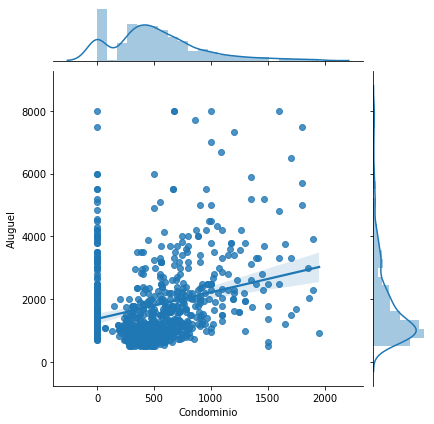

In [ ]:
sns.jointplot(y= campinas['Aluguel'],x = campinas['Condominio'],kind ='reg')

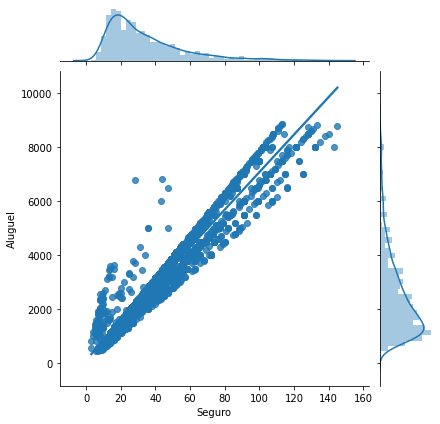

In [ ]:
sns.jointplot(y= rent['Aluguel'],x = rent['Seguro'],kind ='reg')

## Conclusão

Nos gráficos acima não consegui ver uma relação direta entre IPTU e condominio, mas o seguro contra incendio mostrou grande correlação. Isso pode ser devido ao fato que o preço possa estar mais relacionado com o valor do apartamento.

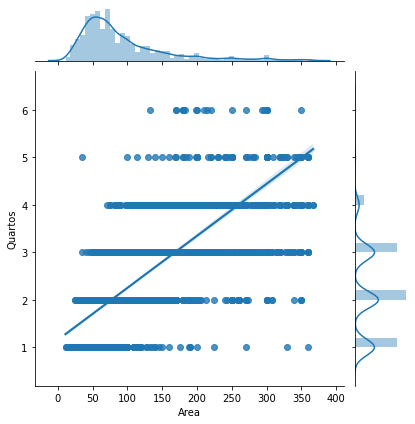

In [ ]:
sns.jointplot(y= rent['Quartos'],x = rent['Area'],kind ='reg')

# Relacionando com valores discretos

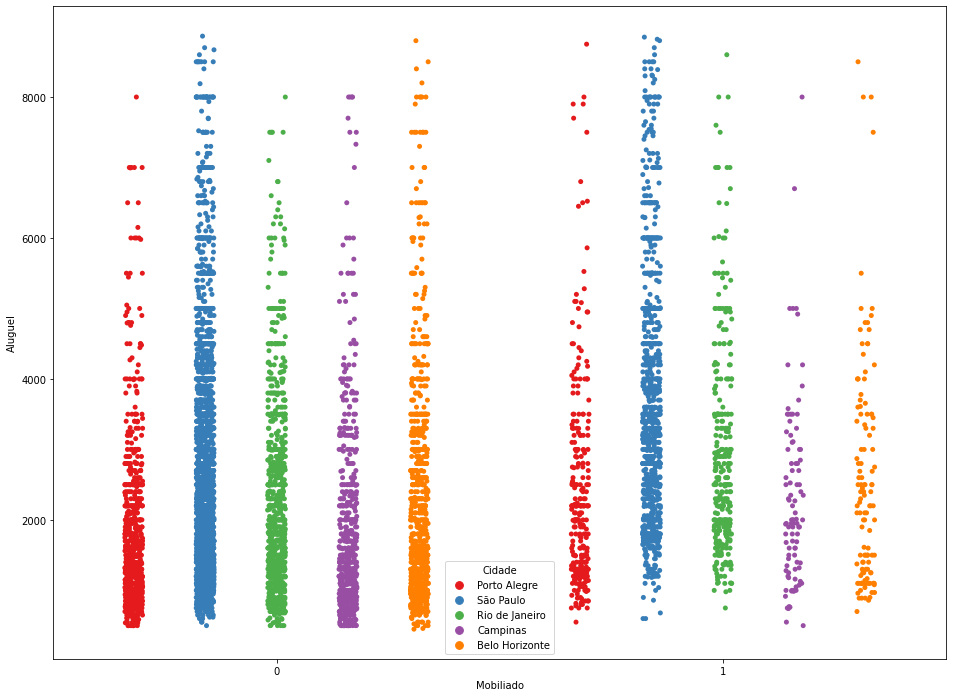

In [ ]:
plt.figure(figsize=(16, 12))
sns.stripplot(x="Mobiliado", y="Aluguel", hue= "Cidade", data=rent, palette="Set1", dodge=True)
plt.show()

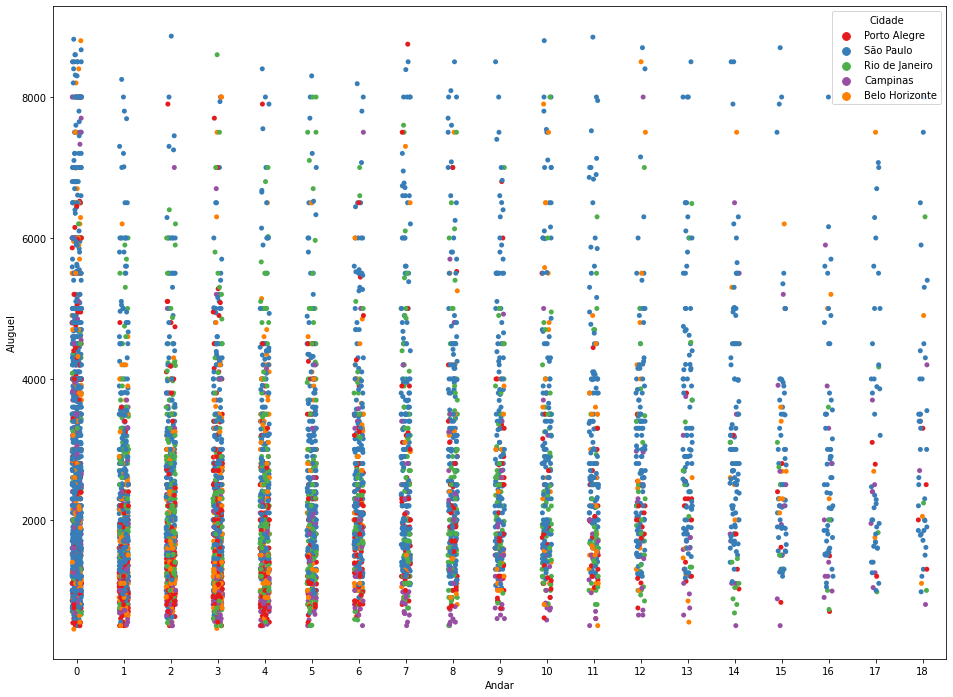

In [ ]:
plt.figure(figsize=(16, 12))
sns.stripplot(x="Andar", y="Aluguel", hue= "Cidade", data=rent, palette="Set1")
plt.show()

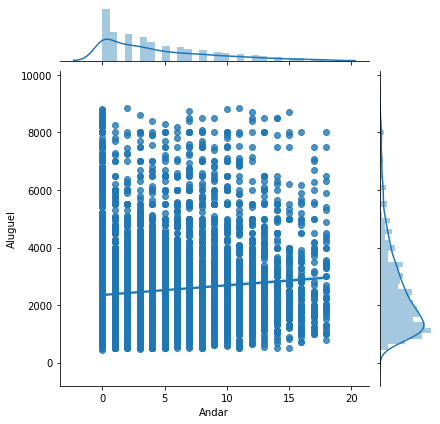

In [ ]:
sns.jointplot(y= rent['Aluguel'],x = rent['Andar'],kind ='reg')

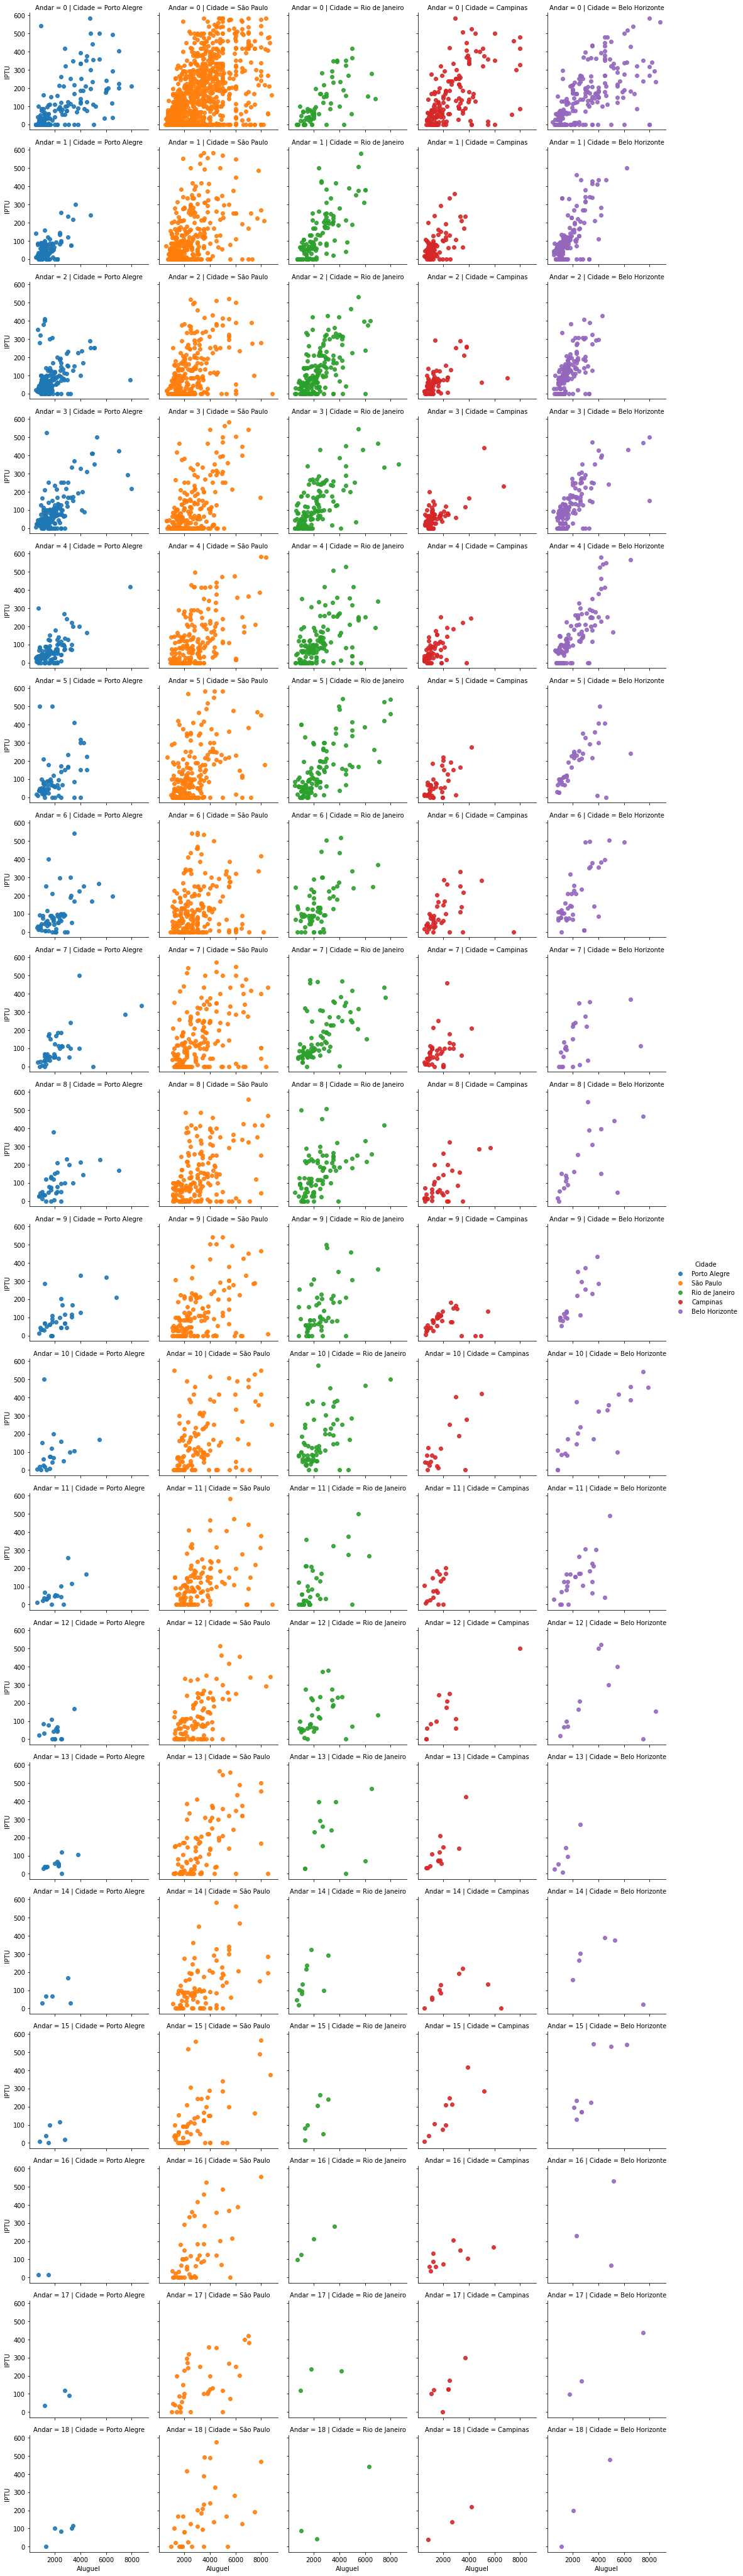

In [ ]:
g = sns.FacetGrid(rent, col="Cidade", row="Andar", hue="Cidade")
g.map(plt.scatter, "Aluguel", "IPTU", alpha=.9)
g.add_legend()
plt.show()

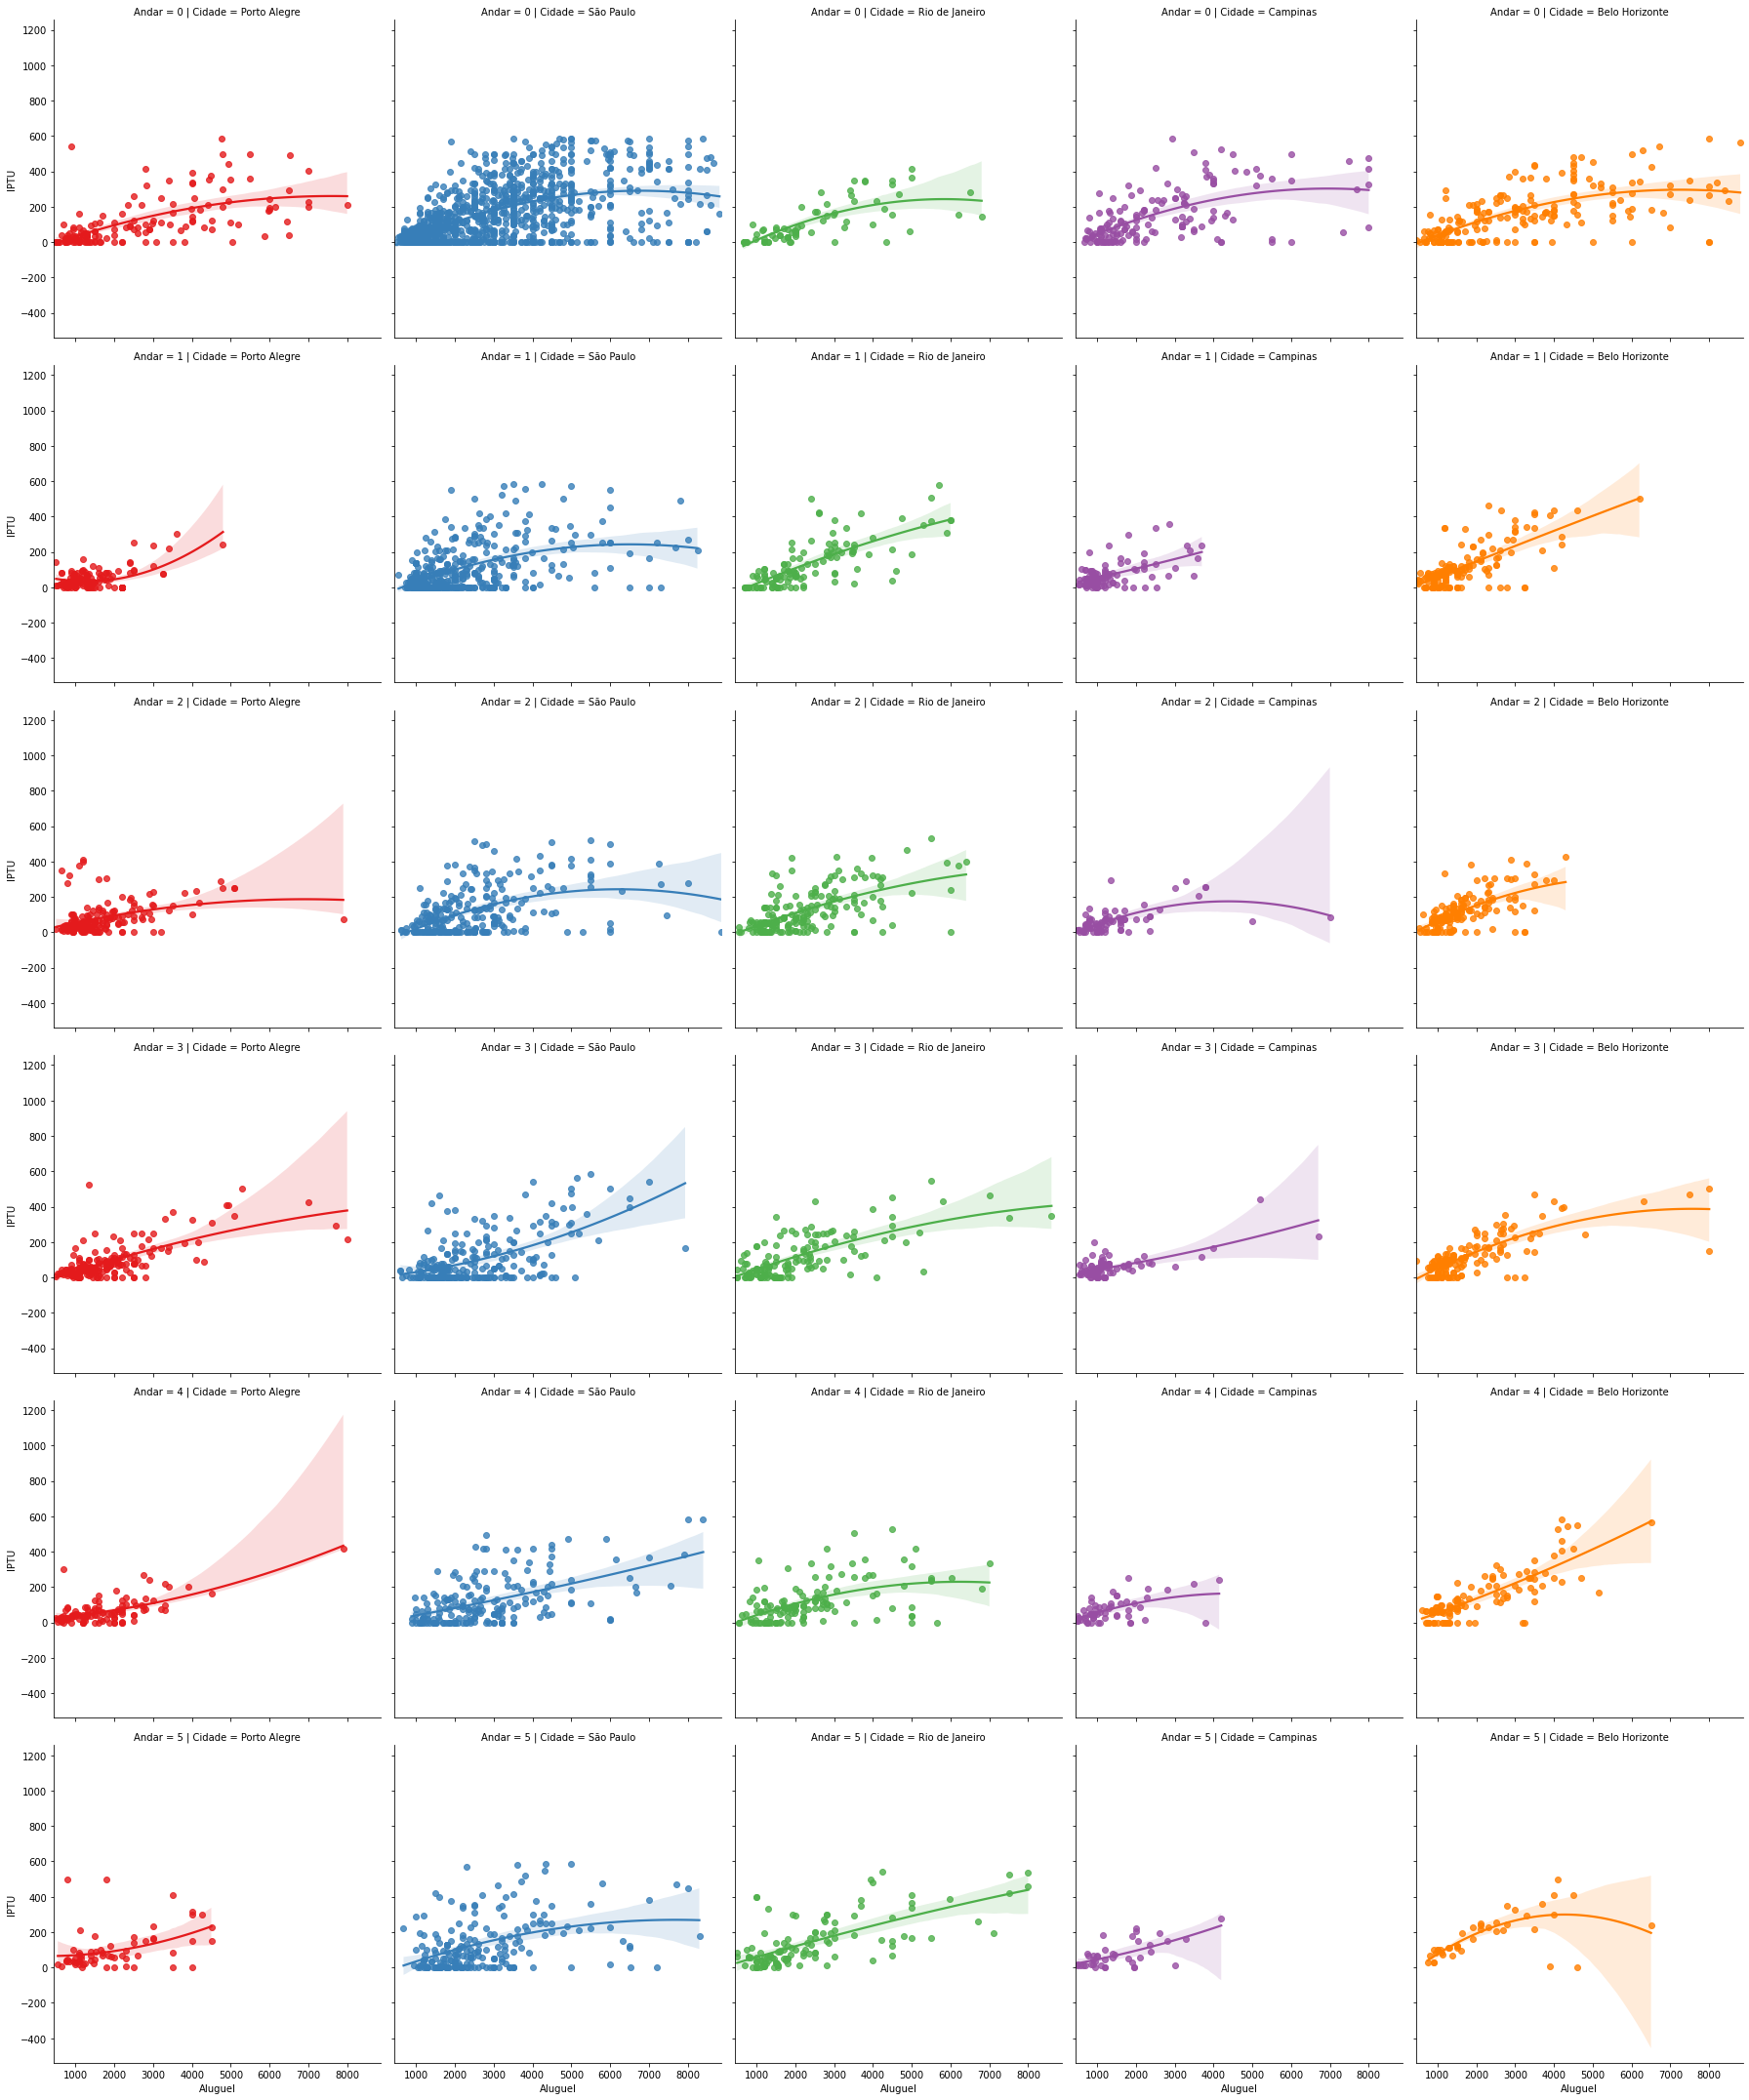

In [ ]:
sns.lmplot(x="Aluguel", y="IPTU", hue="Cidade", col="Cidade",row="Andar",order=2,palette="Set1",data=rent[rent.Andar<6])
plt.show()

In [ ]:
#rent.drop(columns=['Cidade', 'Permite Animal', 'Mobiliado', 'IPTU','Total','Seguro'], inplace=True, errors='ignore')
#rent.dropna(inplace=True)

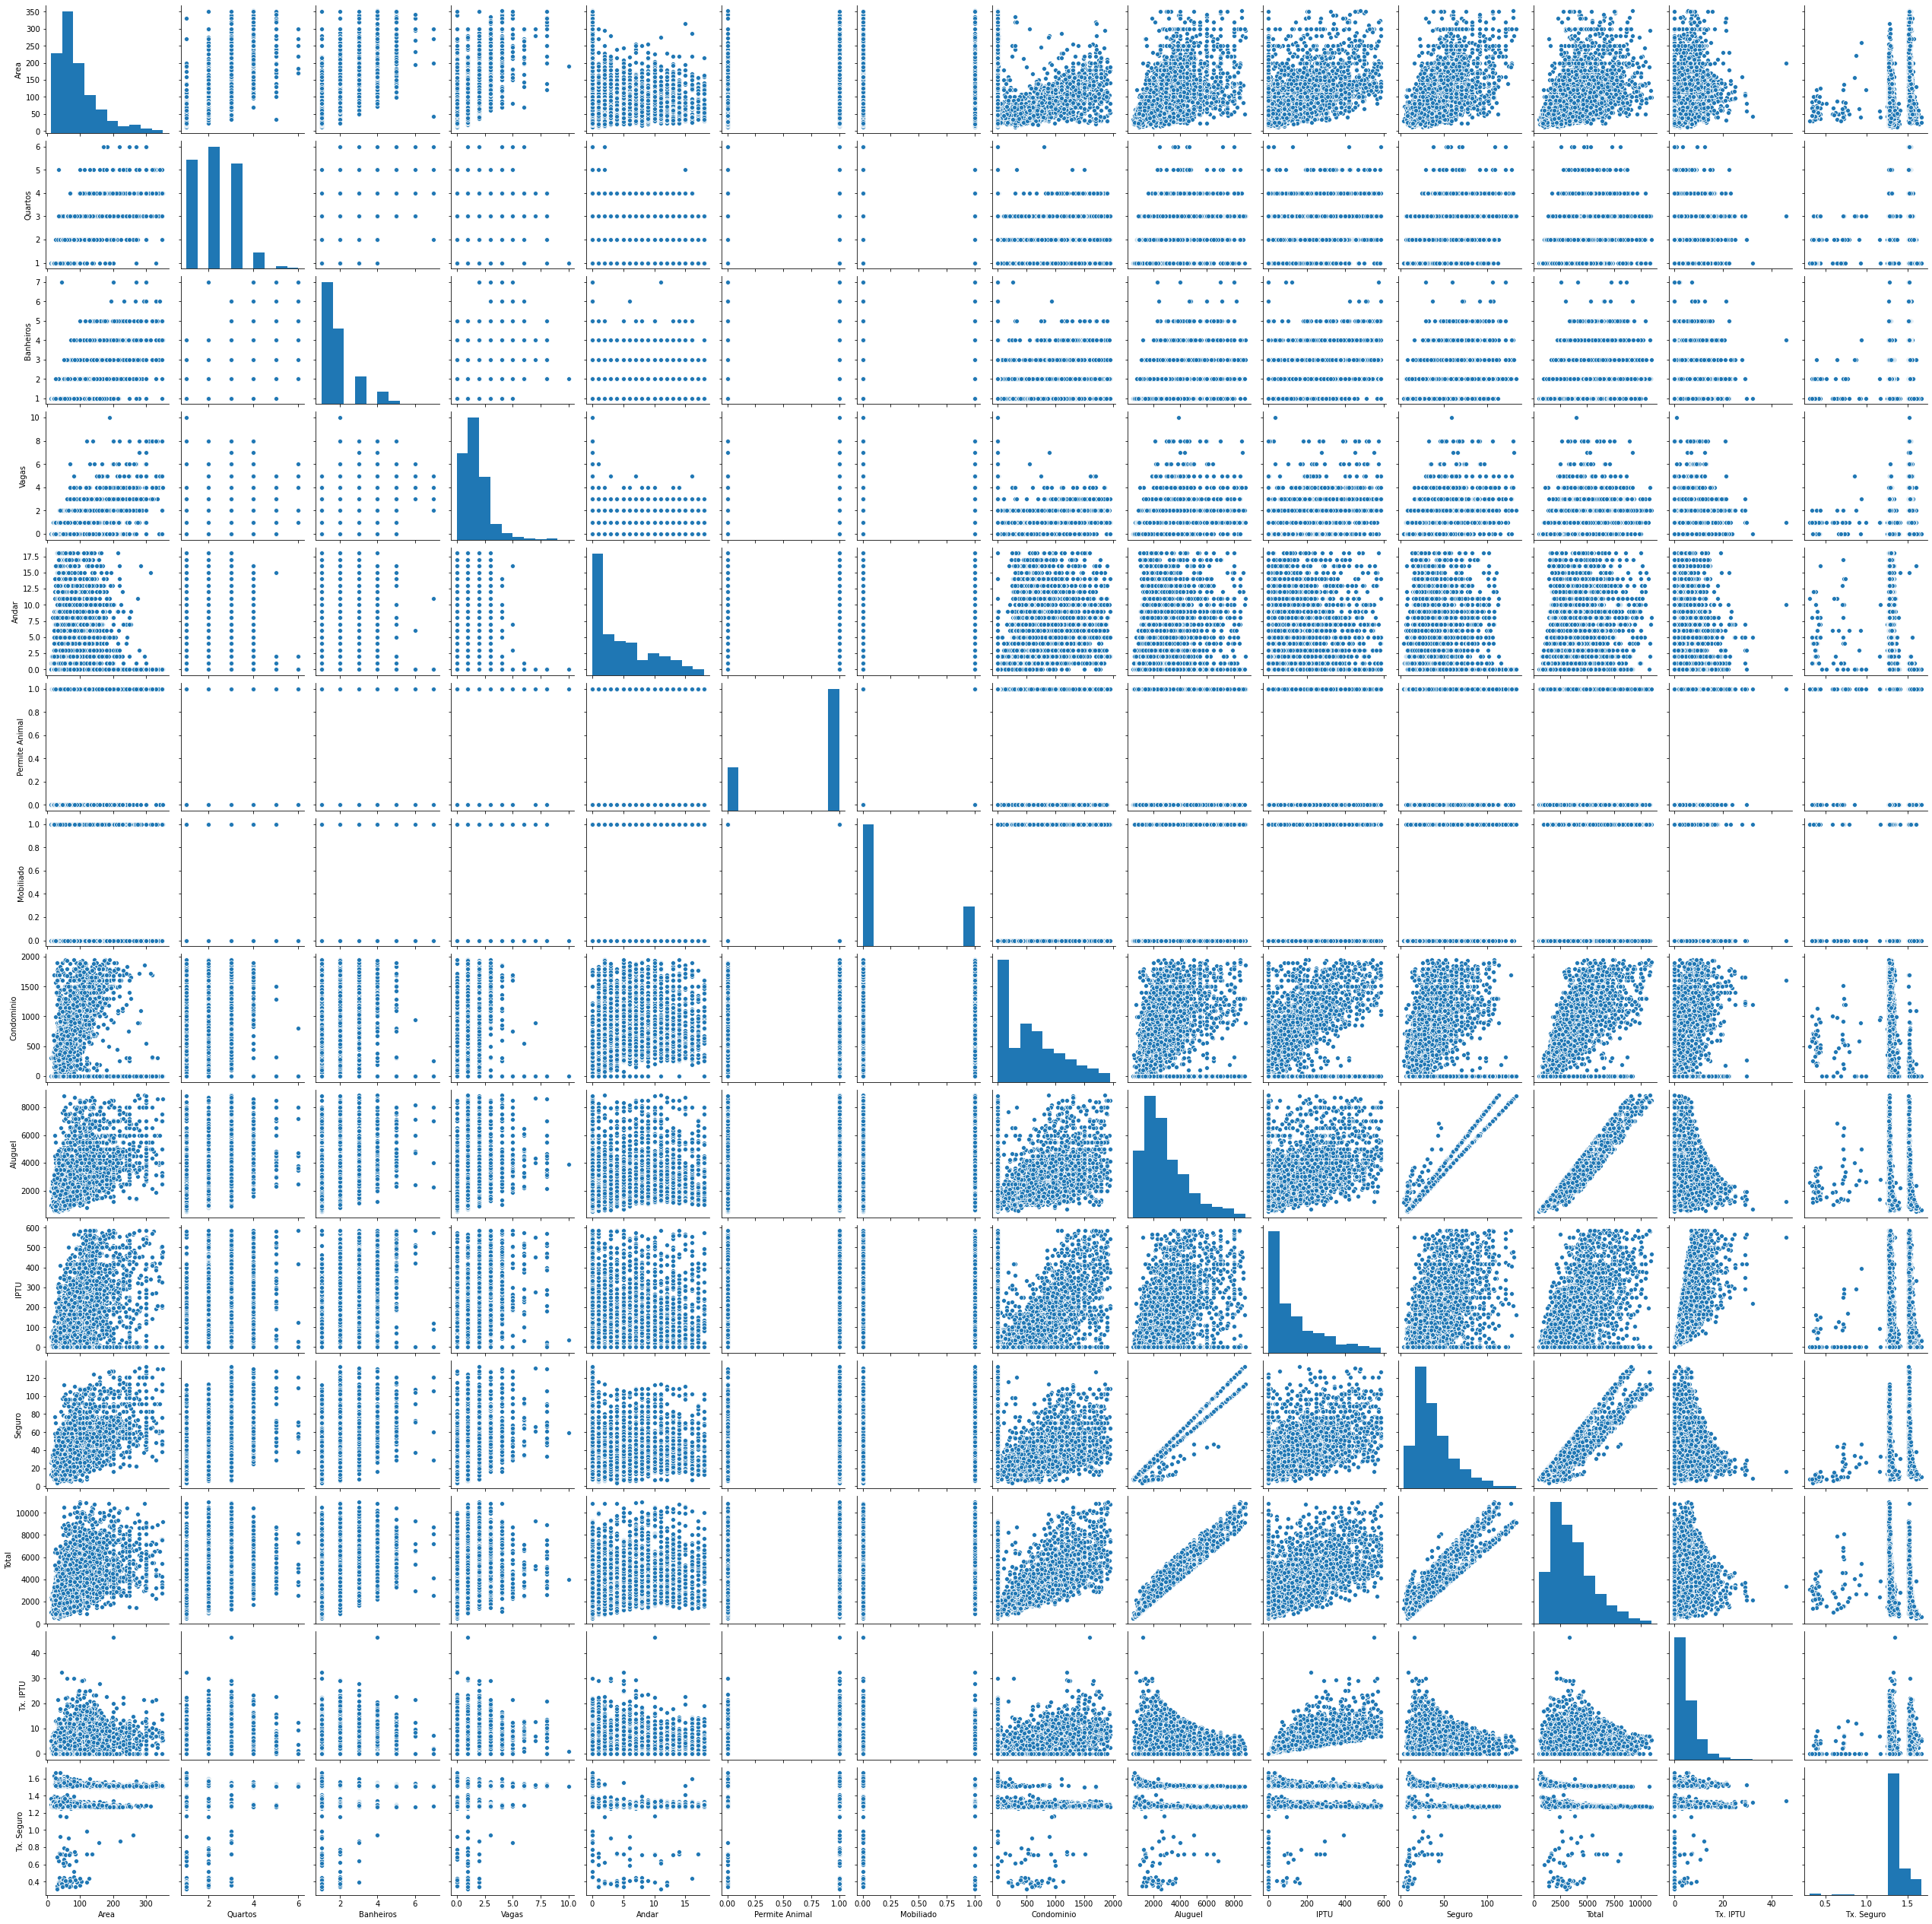

In [ ]:
sns.pairplot(rent[rent.Cidade == "São Paulo"]) 
plt.show()

In [ ]:
def clustering_algorithm(n_clusters, dataset):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(dataset)
    s = metrics.silhouette_score(dataset, labels, metric='euclidean')
    dbs = metrics.davies_bouldin_score(dataset, labels)
    calinski = metrics.calinski_harabasz_score(dataset, labels)
    return s, dbs, calinski, labels

In [ ]:
s, dbs, calinski, labels = clustering_algorithm(3, rent[rent.columns[1:]])
print('Silhoutte: ', s, 'Davies-Bouldin: ', dbs, 'Calinski-Harabasz: ', calinski)

Silhoutte:  0.5334011165229944 Davies-Bouldin:  0.6440494404316884 Calinski-Harabasz:  16619.191701111617


In [ ]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 4436, 1: 826, 2: 2662}

In [ ]:
s2, dbs2, calinski2, labels2 = clustering_algorithm(5, rent[rent.columns[1:]])
print('Silhoutte: ', s2, 'Davies-Bouldin: ', dbs2, 'Calinski-Harabasz: ', calinski2)

Silhoutte:  0.4351200764883219 Davies-Bouldin:  0.7677782121567935 Calinski-Harabasz:  17679.724057211737


In [ ]:
unique, counts = np.unique(labels2, return_counts=True)
dict(zip(unique, counts))

{0: 1573, 1: 2805, 2: 375, 3: 2329, 4: 842}

In [ ]:
s3, dbs3, calinski3, labels3 = clustering_algorithm(7, rent[rent.columns[1:]])
print('Silhoutte: ', s3, 'Davies-Bouldin: ', dbs3, 'Calinski-Harabasz: ', calinski3)

Silhoutte:  0.37197224414290203 Davies-Bouldin:  0.8844048251841455 Calinski-Harabasz:  16614.01597228407


In [ ]:
unique, counts = np.unique(labels3, return_counts=True)
dict(zip(unique, counts))

{0: 1933, 1: 1192, 2: 211, 3: 410, 4: 1519, 5: 737, 6: 1922}

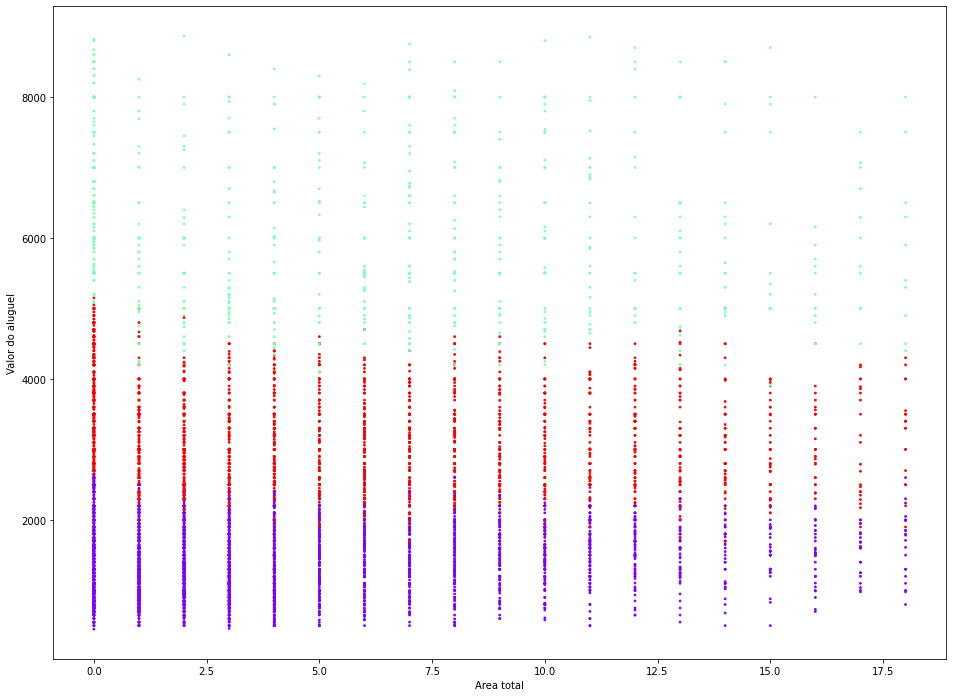

In [ ]:
plt.figure(figsize=(16, 12))
plt.scatter(rent['Andar'], rent['Aluguel'], c=labels, s=3, cmap='rainbow')
plt.xlabel("Area total")
plt.ylabel("Valor do aluguel")
plt.show()

In [ ]:
rent['Cluster'] = labels
rent

Cidade  Area  Quartos  ...   Tx. IPTU  Tx. Seguro  Cluster
2        Porto Alegre    80        1  ...   0.000000    1.464286        2
3        Porto Alegre    51        2  ...   1.978417    1.528777        0
4           São Paulo    25        1  ...   3.125000    1.375000        0
6      Rio de Janeiro    72        2  ...   4.473684    1.315789        0
9      Rio de Janeiro    35        1  ...   1.521739    1.304348        0
...               ...   ...      ...  ...        ...         ...      ...
10684  Rio de Janeiro    98        2  ...   4.717949    1.307692        2
10685       São Paulo    83        3  ...   2.938439    1.276426        1
10687    Porto Alegre    63        2  ...   1.623816    1.488498        0
10689  Rio de Janeiro    70        3  ...   5.533333    1.300000        1
10691       São Paulo    80        2  ...  11.785714    1.571429        0

[7924 rows x 16 columns]

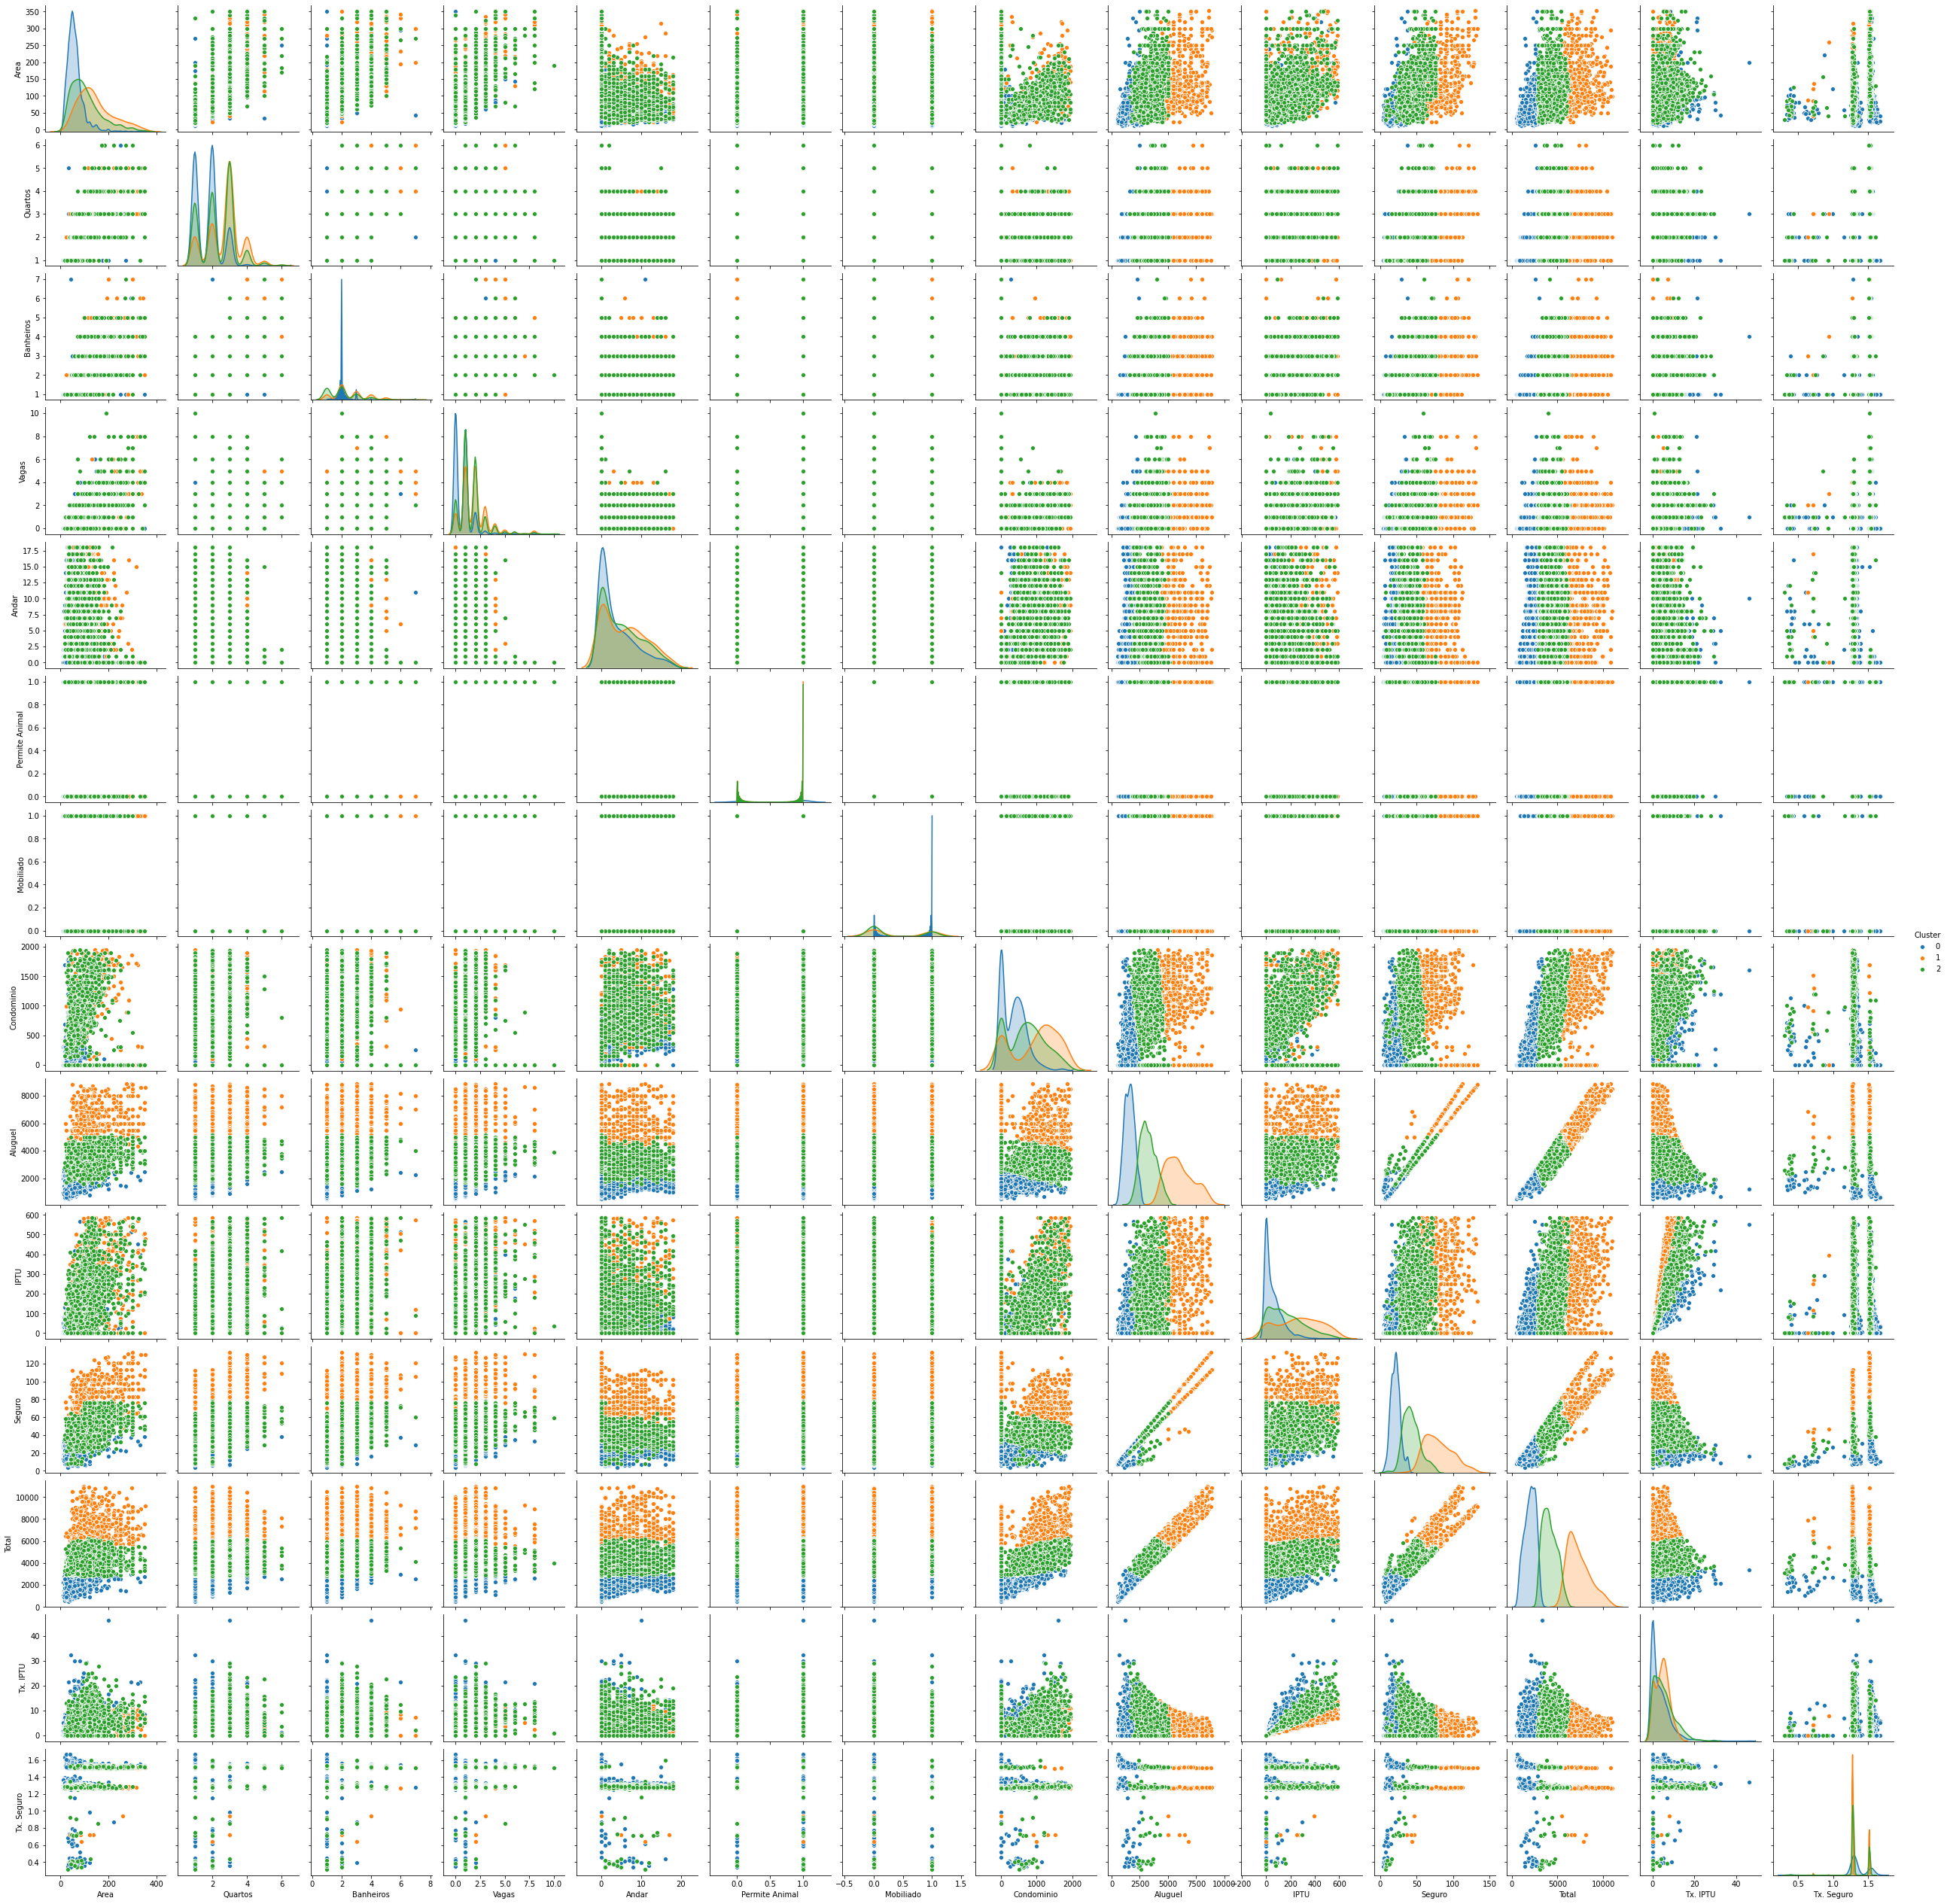

In [ ]:
sns.pairplot(rent[rent.Cidade == "São Paulo"], hue="Cluster") 
plt.show()